In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

NOTES:
the code written before this file: 'command_temporal_order_analysis.ipynb'

To Do: 
The Vector Difference between movement-command activity and mean-command activity (move-mean) vs (shuffle-mean)
Individual Neuron Difference (mean, move, shuffle)
Example: for a chosen command and all shuffle distribution, move distribution, dotted line for global mean.
(The example is a tougher scenario... save till end.  That's because we'd like the activity to be for the same command without matching needed)


In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [6]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


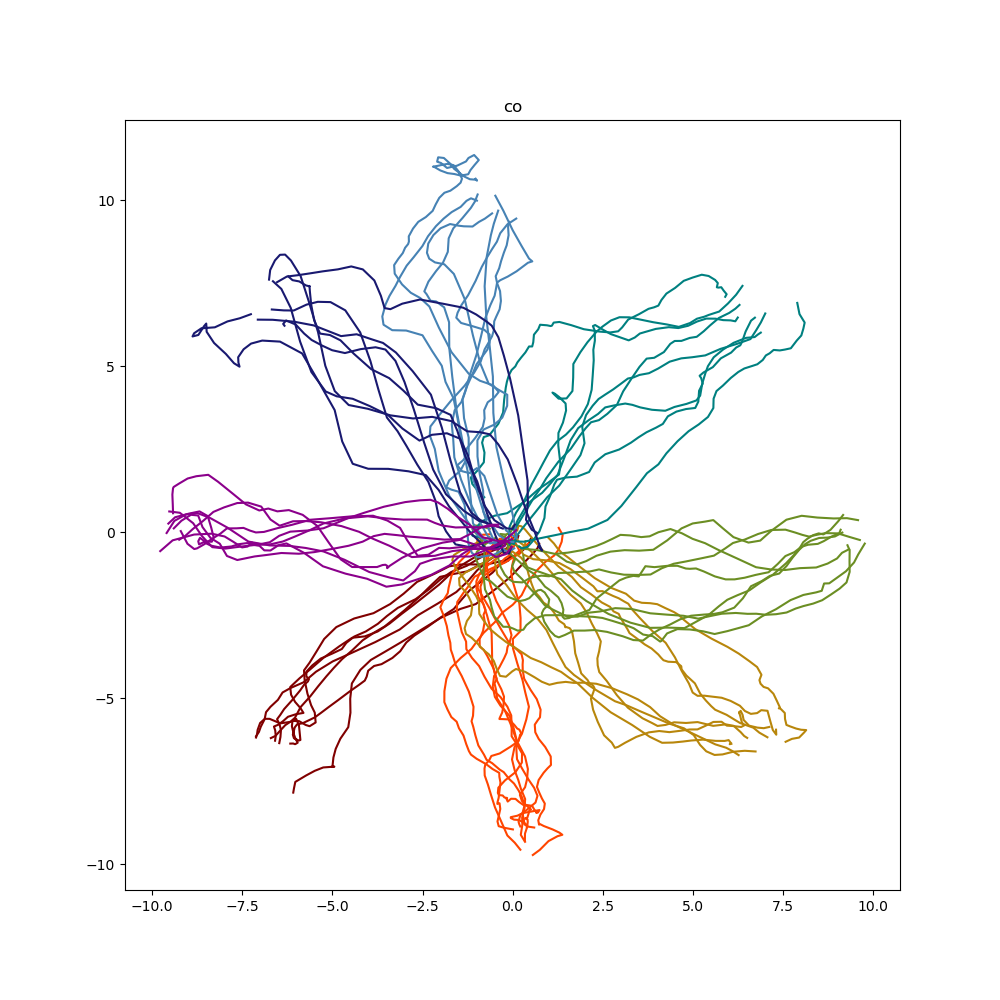

<IPython.core.display.Javascript object>


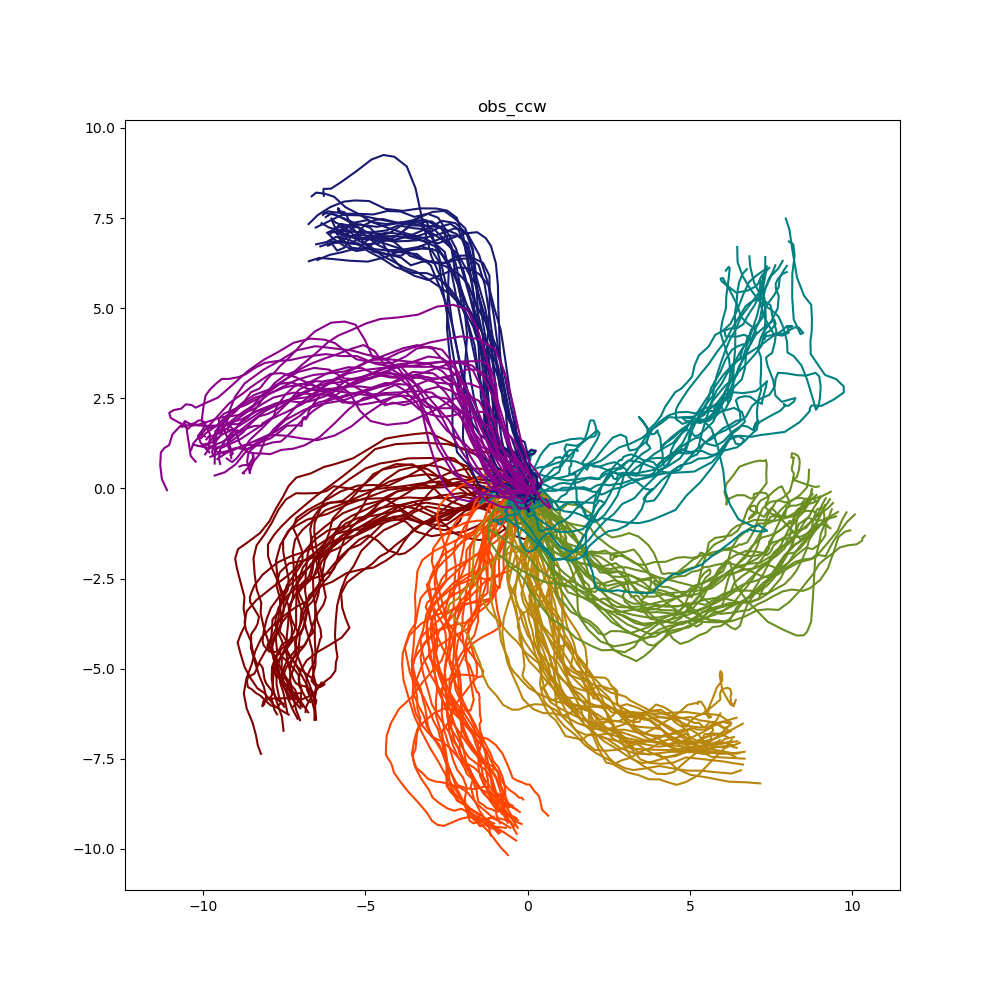

<IPython.core.display.Javascript object>


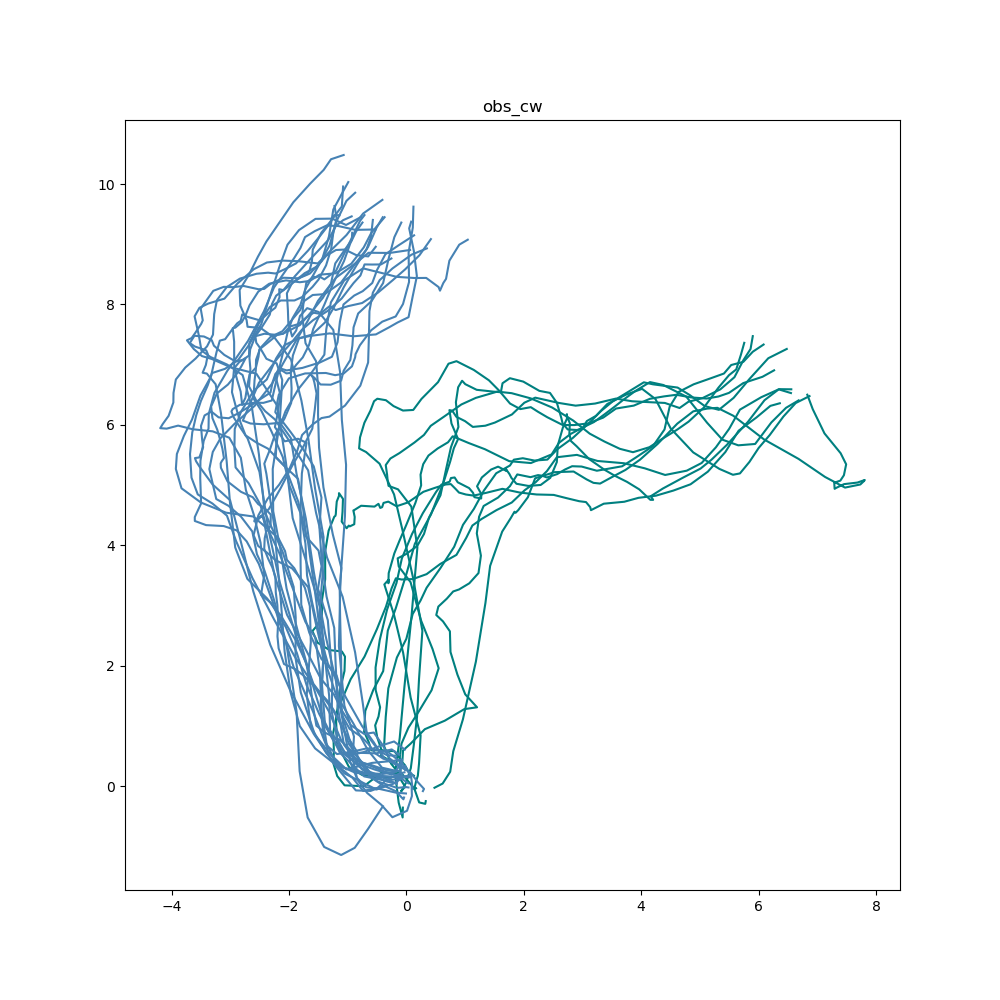

In [7]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [8]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)

<IPython.core.display.Javascript object>


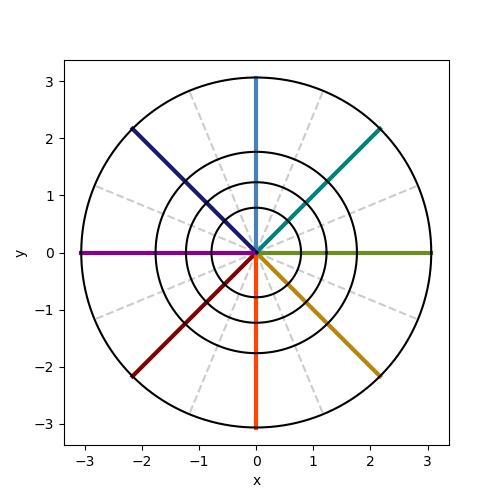

In [9]:
plt.figure(figsize=(5,5))
plot_command_bin()

### Define movement list.  For each command, identify movements which have enough observations of each command.

In [227]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        

In [232]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [233]:
move_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [241]:
sel

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
14688    False
14689    False
14690    False
14691    False
14692    False
14693    False
14694    False
14695    False
14696    False
14697    False
14698    False
14699    False
14700    False
14701    False
14702    False
14703    False
14704    False
14705    False
14706    False
14707    False
14708    False
14709    False
14710    False
14711    False
14712    False
14713    False
14714    False
14715    False
14716    False
14717    False
Length: 14718, dtype: bool

In [242]:
sum(sel)

0

In [244]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.

### For each command, identify the subset of the pool command distribution which matches command mean

In [301]:
t_start = timeit.default_timer()

In [302]:
t_start

487.2833263

In [303]:
#Loop command+movement: 
var = ['u_vx', 'u_vy'] #just to start with 
match_var = var
p_sig = 0.2
max_discard = 150

t_start = timeit.default_timer()

c_list_d = [c_list[10]]
for c in c_list:
    c_idx = df[cm_dic[c,'sel']].index.values
    c_da = bmi_b.df_idx2da(df,c_idx,var)
    cm_list = cm_dic[c]
#     print(cm_list)
#     cm_list_d = [cm_list[0]]
    for m in cm_list:
        cm_idx = df[cm_dic[c,m,'sel']].index.values
        cm_da = bmi_b.df_idx2da(df,cm_idx,var)
        #match distributions:
        d_list=[c_da, cm_da]
        print(c,m)
        success, kept_list, discard_list, df_match, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=p_sig, max_iter=max_discard)
        #kept_list: 
        #idx 0: idxs from c_da to keep 
        #idx 1: idxs from cm_da to keep
        
        cm_dic[c,m,'pool_match_idx'] = kept_list[0]
        cm_dic[c,m,'pool_match_success'] = success
        cm_dic[c,m,'pool_match_discard'] = discard_list[0]
        cm_dic[c,m,'pool_match_ttest'] = ttest_r
        cm_dic[c,m,'pool_match_mean'] = mean_r    
        
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed/(60.0*60.0))

((0, 0), (0, 1.1))
matched!
((0, 0), (1, 1.1))
matched!
((0, 0), (2, 1.1))
matched!
((0, 0), (3, 1.1))
matched!
((0, 0), (4, 1.1))
matched!
((0, 1), (0, 1.1))
matched!
((0, 1), (1, 1.1))
matched!
((0, 1), (2, 1.1))
matched!
((0, 1), (3, 1.1))
matched!
((0, 1), (4, 1.1))
matched!
((0, 2), (0, 1.1))
matched!
((0, 2), (1, 0))
matched!
((0, 2), (1, 1.1))
matched!
((0, 2), (2, 0))
matched!
((0, 2), (2, 1.1))
matched!
((0, 2), (3, 1.1))
matched!
((0, 2), (4, 1.1))
matched!
((0, 3), (2, 1.1))
matched!
((0, 3), (3, 1.1))
matched!
((0, 3), (4, 1.1))
matched!
((0, 3), (4, 1.2))
matched!
((0, 3), (5, 1.2))
matched!
((0, 4), (2, 1.1))
matched!
((0, 4), (3, 1.1))
matched!
((0, 4), (4, 1.1))
matched!
((0, 4), (4, 1.2))
matched!
((0, 4), (5, 1.2))
matched!
((0, 5), (2, 1.1))
matched!
((0, 5), (3, 1.1))
matched!
((0, 5), (4, 1.1))
matched!
((0, 5), (4, 1.2))
matched!
((0, 5), (5, 1.2))
matched!
((0, 6), (3, 1.1))
matched!
((0, 6), (4, 1.1))
matched!
((0, 6), (5, 1.2))
matched!
((0, 7), (3, 1.1))
match

### Shuffle movement+time label of each command observation, to serve as a control

In [305]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 1000
for c in c_list:
    for m in cm_dic[c]:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        num_obs = cm_dic[c,m,'num_obs']
        shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
        for s in range(num_shuffle):
            shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
        #ASSIGN:
        cm_dic[c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start            

### Implement the analysis of comparing command-activity:

In [306]:
#let's calculate the true vector diff vs shuffle vector diff:
#true mean, shuffle mean, pool-match mean
for c in c_list:
    for m in cm_dic[c]:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        cm_idxs = cm_dic[c,m,'sel'][cm_dic[c,m,'sel']].index.values

In [307]:
cm_idxs

array([ 7724,  7725,  7727,  7728,  7754,  7755,  7756,  7759,  7763,
        7791,  7796,  7798,  7801,  7805,  7808,  7838,  7839,  7842,
        7844,  7846,  7848,  7877,  7879,  7880,  7882,  7890,  7891,
        7921,  7922,  7923,  7925,  7930,  7932,  7965,  7967,  7968,
        7975,  7986,  8018,  8020,  8023,  8025,  8026,  8034,  8059,
        8066,  8070,  8102,  8106,  8109,  8114,  8142,  8147,  8149,
        8150,  8151,  8167,  8203,  8211,  8213,  8241,  8252,  8253,
        8254,  8255, 14149, 14153, 14156, 14160, 14193, 14194, 14198,
       14199, 14200, 14229, 14231, 14233, 14234, 14236, 14275, 14277,
       14280, 14302, 14304, 14317, 14342, 14345, 14353, 14356, 14385,
       14388, 14391, 14395, 14423, 14428, 14433, 14435, 14444, 14483,
       14489, 14492, 14496, 14534, 14536, 14538, 14539, 14541, 14543,
       14549, 14575, 14578, 14579, 14581, 14617, 14620, 14628, 14709],
      dtype=int64)

In [308]:
c_idxs

[18,
 24,
 36,
 72,
 77,
 78,
 112,
 113,
 120,
 131,
 157,
 161,
 187,
 190,
 194,
 195,
 234,
 245,
 282,
 2639,
 2644,
 2680,
 2681,
 2683,
 2687,
 2688,
 2698,
 2727,
 2733,
 2734,
 2766,
 2769,
 2771,
 2773,
 2776,
 2777,
 2801,
 2802,
 2804,
 2807,
 2840,
 2847,
 2848,
 2849,
 2873,
 2877,
 2880,
 2881,
 2882,
 2884,
 2911,
 2917,
 2918,
 2920,
 2921,
 2924,
 2929,
 2931,
 2952,
 2957,
 2958,
 2963,
 2998,
 2999,
 3000,
 3003,
 3006,
 3013,
 3045,
 3047,
 3086,
 3095,
 3099,
 3135,
 3186,
 3187,
 3188,
 3189,
 3193,
 3233,
 3234,
 3237,
 3249,
 3279,
 3280,
 3286,
 3288,
 3327,
 3331,
 3333,
 3339,
 3373,
 3378,
 3379,
 3381,
 3383,
 3393,
 3429,
 3433,
 3472,
 3490,
 3514,
 3517,
 3520,
 3522,
 3571,
 3572,
 3573,
 3625,
 3626,
 3679,
 3680,
 3717,
 3720,
 3783,
 3829,
 3865,
 3875,
 3919,
 4024,
 4026,
 4132,
 4133,
 4152,
 7257,
 7259,
 7260,
 7290,
 7292,
 7328,
 7329,
 7333,
 7364,
 7389,
 7402,
 7405,
 7439,
 7445,
 7481,
 7518,
 7519,
 7556,
 7585,
 7588,
 7598,
 7599,
 76